In [6]:
# cond_ddpm_1d.py
import math, argparse
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# -----------------------------
# toy function: f(x) = 1/(1+25x^2)
# -----------------------------
def target_fn(x):
    return 1.0 / (1.0 + 25.0 * x**2)

# -----------------------------
# time embedding
# -----------------------------
def sinusoidal_time_embedding(t, dim):
    """
    t: (B,) int64 timesteps in [0, T-1]
    return: (B, dim)
    """
    device = t.device
    half = dim // 2
    freqs = torch.exp(torch.linspace(math.log(1.0), math.log(10000.0), half, device=device))
    args = t.float().unsqueeze(1) / 1000.0
    emb = torch.cat([torch.sin(args * freqs), torch.cos(args * freqs)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0,1))
    return emb

# -----------------------------
# epsilon network: predict noise on y, conditioned on x and t
# input: y_t (1), x (1), t_emb (D)
# output: eps_hat (1)
# -----------------------------
class EpsMLP(nn.Module):
    def __init__(self, time_dim=64, hidden=256):
        super().__init__()
        self.time_dim = time_dim
        self.t_proj = nn.Sequential(nn.Linear(time_dim, hidden), nn.SiLU())
        self.net = nn.Sequential(
            nn.Linear(hidden + 2, hidden),  # [y_t, x] + t_proj
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, y_t, x, t):
        # y_t, x: (B,1); t: (B,)
        t_emb = sinusoidal_time_embedding(t, self.time_dim)
        h_t = self.t_proj(t_emb)
        h = torch.cat([y_t, x, h_t], dim=1)
        return self.net(h)

# -----------------------------
# DDPM 1D (conditional on x)
# -----------------------------
class DDPM1D:
    def __init__(self, model, timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.model = model.to(device)
        self.device = device
        self.T = timesteps

        betas = torch.linspace(beta_start, beta_end, self.T, device=device)
        alphas = 1.0 - betas
        a_bar = torch.cumprod(alphas, dim=0)

        self.betas = betas
        self.alphas = alphas
        self.a_bar = a_bar
        self.sqrt_ab = torch.sqrt(a_bar)
        self.sqrt_one_minus_ab = torch.sqrt(1.0 - a_bar)
        self.sqrt_recip_alpha = torch.sqrt(1.0 / alphas)

    # q: y_t = sqrt(a_bar_t) y0 + sqrt(1-a_bar_t) eps
    def q_sample(self, y0, t, noise=None):
        noise = torch.randn_like(y0) if noise is None else noise
        sa = self.sqrt_ab[t].view(-1,1)
        som = self.sqrt_one_minus_ab[t].view(-1,1)
        return sa * y0 + som * noise

    # Algorithm 1: training loss (predict eps)
    def training_loss(self, x, y0):
        B = x.size(0)
        t = torch.randint(0, self.T, (B,), device=self.device).long()
        noise = torch.randn_like(y0)
        y_t = self.q_sample(y0, t, noise)
        eps_hat = self.model(y_t, x, t)
        return F.mse_loss(eps_hat, noise)

    # Algorithm 2: single p step
    @torch.no_grad()
    def p_sample(self, y_t, x, t):
        # x, y_t: (B,1); t: int
        t_batch = torch.full((y_t.size(0),), t, device=self.device, dtype=torch.long)
        eps_hat = self.model(y_t, x, t_batch)

        beta_t = self.betas[t]
        alpha_t = self.alphas[t]
        sqrt_recip_alpha_t = self.sqrt_recip_alpha[t]
        sqrt_one_minus_ab_t = self.sqrt_one_minus_ab[t]

        mean = sqrt_recip_alpha_t * (y_t - (beta_t / sqrt_one_minus_ab_t) * eps_hat)

        if t == 0:
            return mean
        else:
            z = torch.randn_like(y_t)
            return mean + torch.sqrt(beta_t) * z

    @torch.no_grad()
    def sample(self, x_grid):
        """
        x_grid: (N,1)
        return y samples aligned with x_grid
        """
        self.model.eval()
        y_t = torch.randn_like(x_grid)  # start from N(0,1)
        for t in reversed(range(self.T)):
            y_t = self.p_sample(y_t, x_grid, t)
        return y_t

# -----------------------------
# data utilities
# -----------------------------
def make_dataset(n_train=4096, noise_std=0.0, device="cpu"):
    # sample x ~ Uniform[-1,1], y0 = f(x) (+ optional small obs noise)
    x = torch.rand(n_train, 1) * 2 - 1
    y = target_fn(x)
    if noise_std > 0:
        y = y + noise_std * torch.randn_like(y)
    return x.to(device), y.to(device)

def get_loader(x, y, batch_size=256):
    ds = TensorDataset(x, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

# -----------------------------
# train & sample runners
# -----------------------------
def train(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = EpsMLP(time_dim=64, hidden=256)
    ddpm = DDPM1D(model, timesteps=args.T, device=device)

    x, y = make_dataset(n_train=args.n_train, noise_std=args.obs_noise, device=device)
    dl = get_loader(x, y, batch_size=args.batch_size)

    opt = torch.optim.AdamW(model.parameters(), lr=args.lr)

    out = Path(args.out_dir); out.mkdir(parents=True, exist_ok=True)
    step = 0
    model.train()
    for epoch in range(args.epochs):
        for xb, yb in dl:
            loss = ddpm.training_loss(xb, yb)              # === Algorithm 1 ===
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            step += 1
            if step % args.log_every == 0:
                print(f"[epoch {epoch}] step {step}  loss {loss.item():.6f}")

        torch.save(model.state_dict(), out / "cond_ddpm_1d.pt")

def sample(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = EpsMLP(time_dim=64, hidden=256).to(device)
    ddpm = DDPM1D(model, timesteps=args.T, device=device)

    ckpt = Path(args.ckpt)
    assert ckpt.exists(), f"checkpoint not found: {ckpt}"
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()

    # x grid for sampling
    x_grid = torch.linspace(-1, 1, steps=args.n_points, device=device).unsqueeze(1)
    with torch.no_grad():
        y_samp = ddpm.sample(x_grid)                       # === Algorithm 2 ===
        y_true = target_fn(x_grid)

    # save to .csv for plotting elsewhere
    out = Path(args.out_dir); out.mkdir(parents=True, exist_ok=True)
    data = torch.cat([x_grid.cpu(), y_true.cpu(), y_samp.cpu()], dim=1)
    torch.save(data, out / "samples.pt")
    # also dump a simple txt
    with open(out / "samples.txt", "w") as f:
        f.write("x,y_true,y_sample\n")
        for i in range(data.size(0)):
            f.write(f"{data[i,0].item():.6f},{data[i,1].item():.6f},{data[i,2].item():.6f}\n")
    print(f"Saved samples to {out/'samples.txt'} (columns: x, y_true, y_sample)")




In [7]:
# 放在 code.py 的最後
if __name__ == "__main__":
    import sys
    sys.argv = ['']  # 🚑 清掉 Jupyter 自動塞的參數

    class Args:
        out_dir = "./runs_1d"
        T = 500
        n_train = 20000 #4096
        obs_noise = 0.0
        batch_size = 256
        epochs = 200 #30
        lr = 2e-3
        log_every = 100
        train = True   # 要訓練就設 True
        sample = False # 要取樣就設 True
        ckpt = "./runs_1d/cond_ddpm_1d.pt"
        n_points = 201
    args = Args()

    if args.train:
        train(args)
    if args.sample:
        sample(args)


[epoch 1] step 100  loss 0.130388
[epoch 2] step 200  loss 0.144738
[epoch 3] step 300  loss 0.162982
[epoch 5] step 400  loss 0.144105
[epoch 6] step 500  loss 0.124640
[epoch 7] step 600  loss 0.093952
[epoch 8] step 700  loss 0.088118
[epoch 10] step 800  loss 0.081220
[epoch 11] step 900  loss 0.089644
[epoch 12] step 1000  loss 0.090136
[epoch 13] step 1100  loss 0.059147
[epoch 15] step 1200  loss 0.051275
[epoch 16] step 1300  loss 0.034327
[epoch 17] step 1400  loss 0.036177
[epoch 18] step 1500  loss 0.029627
[epoch 20] step 1600  loss 0.049642
[epoch 21] step 1700  loss 0.031680
[epoch 22] step 1800  loss 0.026097
[epoch 24] step 1900  loss 0.021138
[epoch 25] step 2000  loss 0.028051
[epoch 26] step 2100  loss 0.022695
[epoch 27] step 2200  loss 0.012930
[epoch 29] step 2300  loss 0.044888
[epoch 30] step 2400  loss 0.022257
[epoch 31] step 2500  loss 0.030118
[epoch 32] step 2600  loss 0.019763
[epoch 34] step 2700  loss 0.036482
[epoch 35] step 2800  loss 0.019106
[epoch 3

RuntimeError: File runs_1d\cond_ddpm_1d.pt cannot be opened.

In [ ]:
# 切到取樣
args.train = False
args.sample = True
sample(args)   # 會輸出 runs_1d/samples.txt


C:\Users\user\AppData\Local\Temp\ipykernel_14804\1060467004.py:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt, map_location=device)

Saved samples to runs_1d\samples.txt (columns: x, y_true, y_sample)


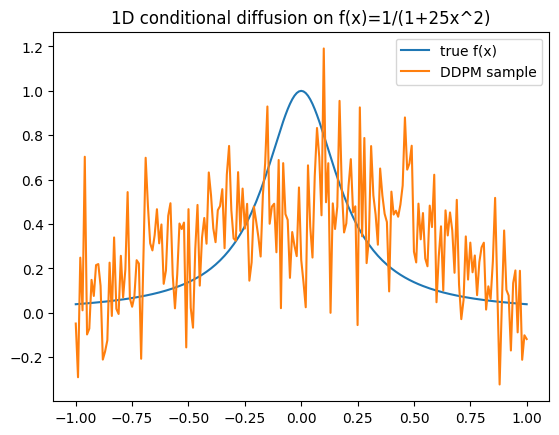

MSE: 0.0950105547335821


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('runs_1d/samples.txt', delimiter=',', skiprows=1)
x, y_true, y_hat = data.T

plt.figure()
plt.plot(x, y_true, label='true f(x)')
plt.plot(x, y_hat, label='DDPM sample')
plt.legend()
plt.title('1D conditional diffusion on f(x)=1/(1+25x^2)')
plt.show()

# 簡單誤差
mse = ((y_true - y_hat)**2).mean()
print('MSE:', mse)
